In [14]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import mktime
import time

In [8]:
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

In [10]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo from storageinfo where datestamp between '2022-06-01 00:00:00' and now()) as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-06-01 00:00:00") \
     .option("upperBound", "2022-06-26 23:59:59") \
     .option("fetchsize", 1000000) \
     .load()

df.printSchema()

root
 |-- queuedtime: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- vo: string (nullable = true)



In [11]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,queuedtime,bigint
1,fullsize,bigint
2,storageclass,string
3,connectiontime,bigint
4,action,string
5,cellname,string
6,datestamp,timestamp
7,errorcode,int
8,errormessage,string
9,pnfsid,string


In [15]:
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  13454258  Time to execute  488.36044573783875


In [16]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

DataFrame[queuedtime: bigint, fullsize: bigint, storageclass: string, connectiontime: bigint, action: string, cellname: string, datestamp: timestamp, errorcode: int, errormessage: string, pnfsid: string, transaction: string, vo: string]

Number of entries again =====>  13456032  Time to execute  731.048232793808


In [29]:
df_vo = spark.sql("SELECT DISTINCT(vo), COUNT(vo) AS number_of_stores FROM billing WHERE action='store' and errorcode = 0 group by vo order by number_of_stores  desc ")
df_vo.show()

+---------+----------------+
|       vo|number_of_stores|
+---------+----------------+
|   uboone|         4418768|
|     nova|         1121216|
|      GM2|          426806|
|     dune|          145665|
|     mu2e|          126405|
|   icarus|           69739|
|     next|           23774|
|    annie|           13647|
|  snoplus|           10898|
|     lqcd|            2725|
|     test|            1406|
|  accelai|            1362|
|      des|             309|
|fermigrid|             119|
|    e1039|              49|
|   Simons|              28|
|    test2|               2|
| darkside|               2|
|   lariat|               1|
|  backups|               1|
+---------+----------------+



In [30]:
df_vo.count()

20

In [39]:
write_per_store = spark.sql("select DISTINCT(action) from billing where action='store'")
write_per_store.show()

+------+
|action|
+------+
| store|
+------+



In [40]:
unioned_df = write_per_store.join(df_vo)
unioned_df.show(100)

+------+---------+----------------+
|action|       vo|number_of_stores|
+------+---------+----------------+
| store|   uboone|         4418768|
| store|     nova|         1121216|
| store|      GM2|          426806|
| store|     dune|          145665|
| store|     mu2e|          126405|
| store|   icarus|           69739|
| store|     next|           23774|
| store|    annie|           13647|
| store|  snoplus|           10898|
| store|     lqcd|            2725|
| store|     test|            1406|
| store|  accelai|            1362|
| store|      des|             309|
| store|fermigrid|             119|
| store|    e1039|              49|
| store|   Simons|              28|
| store|    test2|               2|
| store| darkside|               2|
| store|   lariat|               1|
| store|  backups|               1|
+------+---------+----------------+



In [41]:
d1=unioned_df.toPandas()
print(d1)

   action         vo  number_of_stores
0   store       nova           1121216
1   store       dune            145665
2   store      e1039                49
3   store     Simons                28
4   store       next             23774
5   store     uboone           4418768
6   store    accelai              1362
7   store        des               309
8   store    snoplus             10898
9   store        GM2            426806
10  store  fermigrid               119
11  store       test              1406
12  store     icarus             69739
13  store      annie             13647
14  store       lqcd              2725
15  store       mu2e            126405
16  store   darkside                 2
17  store      test2                 2
18  store     lariat                 1
19  store    backups                 1


In [42]:
d1=d1.sort_values(by=['number_of_stores'], ascending=False)

In [43]:
print(d1)

   action         vo  number_of_stores
5   store     uboone           4418768
0   store       nova           1121216
9   store        GM2            426806
1   store       dune            145665
15  store       mu2e            126405
12  store     icarus             69739
4   store       next             23774
13  store      annie             13647
8   store    snoplus             10898
14  store       lqcd              2725
11  store       test              1406
6   store    accelai              1362
7   store        des               309
10  store  fermigrid               119
2   store      e1039                49
3   store     Simons                28
16  store   darkside                 2
17  store      test2                 2
18  store     lariat                 1
19  store    backups                 1


<AxesSubplot:xlabel='vo'>

Text(0.5, 0, 'vo')

Text(0, 0.5, 'number_of_stores')

/tmp/ipykernel_26758/2045646321.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('stores.png' ,fontsize=24)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'uboone'),
  Text(1, 0, 'nova'),
  Text(2, 0, 'GM2'),
  Text(3, 0, 'dune'),
  Text(4, 0, 'mu2e'),
  Text(5, 0, 'icarus'),
  Text(6, 0, 'next'),
  Text(7, 0, 'annie'),
  Text(8, 0, 'snoplus'),
  Text(9, 0, 'lqcd'),
  Text(10, 0, 'test'),
  Text(11, 0, 'accelai'),
  Text(12, 0, 'des'),
  Text(13, 0, 'fermigrid'),
  Text(14, 0, 'e1039'),
  Text(15, 0, 'Simons'),
  Text(16, 0, 'darkside'),
  Text(17, 0, 'test2'),
  Text(18, 0, 'lariat'),
  Text(19, 0, 'backups')])

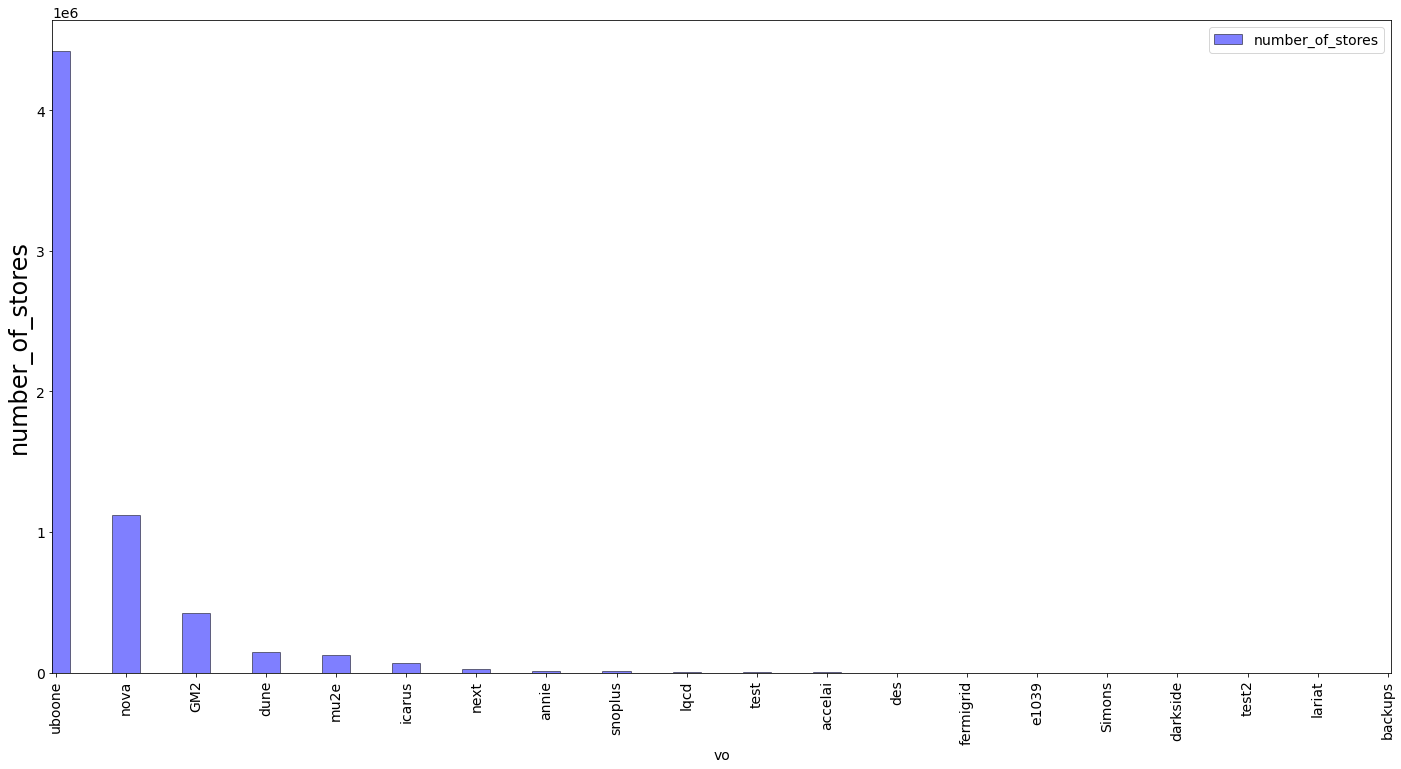

In [44]:
d1.plot.bar(x='vo', y='number_of_stores' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
plt.xlabel("vo")
plt.ylabel("number_of_stores" ,fontsize=24)
plt.savefig('stores.png' ,fontsize=24)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)
plt.show()